# Библиотеките

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import nltk
import numpy as np

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

# Зареждане на данните

In [4]:
data = pd.read_csv('multitude.csv')

In [5]:
data

,text,label,multi_label,split,language,length,source
0,Der Ausbruch des Coronavirus hat die Entwicklu...,1,text-davinci-003,test,de,174,MULTITuDE_MassiveSumm_spiegel
1,Alex Azar was officially sworn in as the U.S. ...,1,text-davinci-003,train,en,57,MULTITuDE_MassiveSumm_voanews
2,Європейський союз вимагає зупинити розтрату ко...,1,gpt-3.5-turbo,test,uk,105,MULTITuDE_MassiveSumm_interfax
3,"Yesterday, hundreds of Zambian university stud...",1,text-davinci-003,train,en,254,MULTITuDE_MassiveSumm_voanews
4,"In a narrow and highly watched vote, the US Se...",1,gpt-4,train,en,416,MULTITuDE_MassiveSumm_voanews
...,...,...,...,...,...,...,...
74076,"Боксер Олег Маскаєв відкрив вболівальникам, що...",1,gpt-3.5-turbo,test,uk,86,MULTITuDE_MassiveSumm_gazeta
74077,A sheriff in the state of Texas has reported t...,1,vicuna-13b,train,en,178,MULTITuDE_MassiveSumm_voanews
74078,-------------Уровень угрозы терроризма в Брита...,1,vicuna-13b,train,ru,60,MULTITuDE_MassiveSumm_bbc
74079,Former President Olusegun Obasanjo is facing a...,1,vicuna-13b,train,en,199,MULTITuDE_MassiveSumm_voanews


text - генериран текст

label - 0 етикет за човешки написан текст, 1 за AI генериран текст

multi_label - генериран езиков модел за изкуствени интелект / human - човешки текст

split - текста за какво ще се използва - тренировъчен сет / тестови сет

language - на какъв международен език е написан текста

length - дължината на текста

source - кой е източника на информация

# Информация за колоните и типовете данни в тях

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74081 entries, 0 to 74080
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         74081 non-null  object
 1   label        74081 non-null  int64 
 2   multi_label  74081 non-null  object
 3   split        74081 non-null  object
 4   language     74081 non-null  object
 5   length       74081 non-null  int64 
 6   source       74081 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.0+ MB


# Проверка на данните

In [16]:
duplicates = data.duplicated()
total_duplicates = duplicates.sum()
print(f"Общо дублирани редове: {total_duplicates}")

Общо дублирани редове: 0


In [17]:
missing_values = data.isnull()
total_missing = missing_values.sum()
print(f"Общо празни стойности: {total_missing}")

Общо празни стойности: text           0
label          0
multi_label    0
split          0
language       0
length         0
source         0
dtype: int64


# Aнализираме и подготвяме данните

In [19]:
data.describe()

,label,length
count,74081.000000,74081.000000
mean,0.892118,152.552962
std,0.310233,93.107789
min,0.000000,6.000000
25%,1.000000,74.000000
50%,1.000000,142.000000
75%,1.000000,215.000000
max,1.000000,512.000000


count – Броят на ненулевите стойности във всяка колона

mean – Средната стойност (аритметичното средно) на всички стойности в колоната

std – Стандартното отклонение: показва колко разпръснати са данните около средната стойност

min – Най-ниската стойност в колоната

25% – Стойността, под която попадат 25% от данните

50% (медиана) – Централната стойност: 50% от стойностите са по-малки, а 50% — по-големи

75% – Стойността, под която са 75% от данните

max – Най-високата стойност в колоната

label
1    66089
0     7992
Name: count, dtype: int64


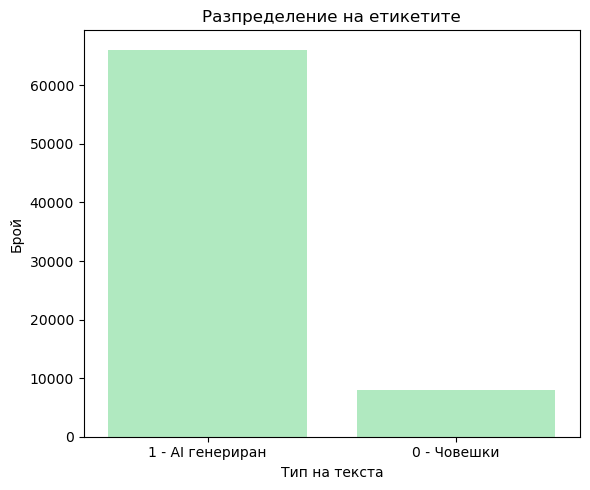

In [28]:
# Разпределение на етикети
duplicate_data = data.copy()
print(duplicate_data['label'].value_counts())

plt.figure(figsize=(6, 5))
sns.countplot(x=duplicate_data['label'].replace({0: '0 - Човешки', 1: '1 - AI генериран'}), color='#A6F3BC')
plt.title('Разпределение на етикетите')
plt.xlabel('Тип на текста')
plt.ylabel('Брой')
plt.tight_layout()
plt.show()

In [29]:
# Брой източници на информация
print(duplicate_data['source'].value_counts())

source
MULTITuDE_MassiveSumm_voanews           26434
MULTITuDE_MassiveSumm_globalvoices       4947
MULTITuDE_MassiveSumm_20minutos          4680
MassiveSumm_voanews                      3107
MULTITuDE_MassiveSumm_ria                2985
                                        ...  
MassiveSumm_golosameriki                   22
MassiveSumm_faz                            14
MassiveSumm_mos                            10
MULTITuDE_MassiveSumm_amerikaninsesi        8
MassiveSumm_golem                           5
Name: count, Length: 75, dtype: int64


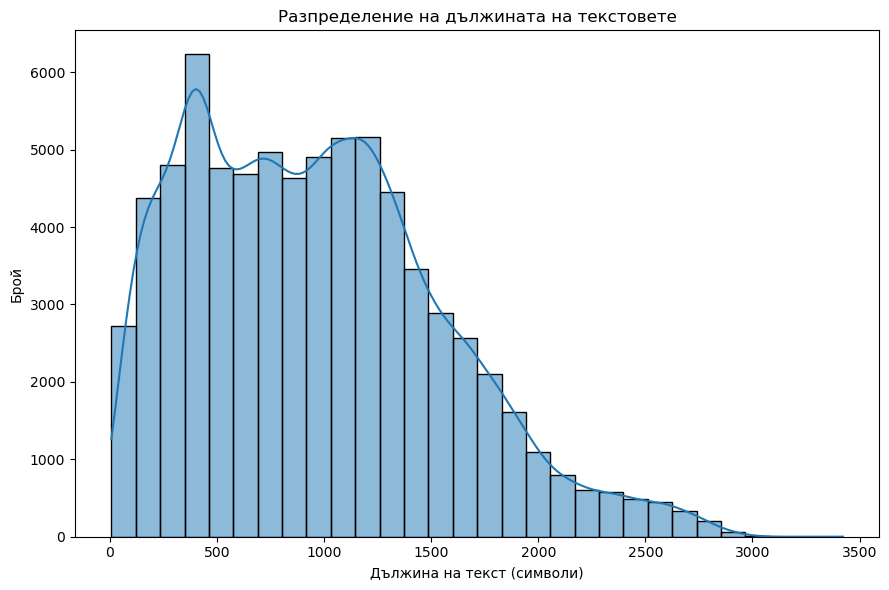

In [30]:
plt.figure(figsize=(9, 6))
sns.histplot(duplicate_data['text'].dropna().apply(len), kde=True, bins=30)
plt.title('Разпределение на дължината на текстовете')
plt.ylabel('Брой')
plt.xlabel('Дължина на текст (символи)')
plt.tight_layout()
plt.show()

Брой записи по езици:
language
en    29460
es    11586
ru    11578
nl     2695
ca     2691
cs     2689
de     2685
zh     2683
pt     2673
ar     2673
uk     2668
Name: count, dtype: int64


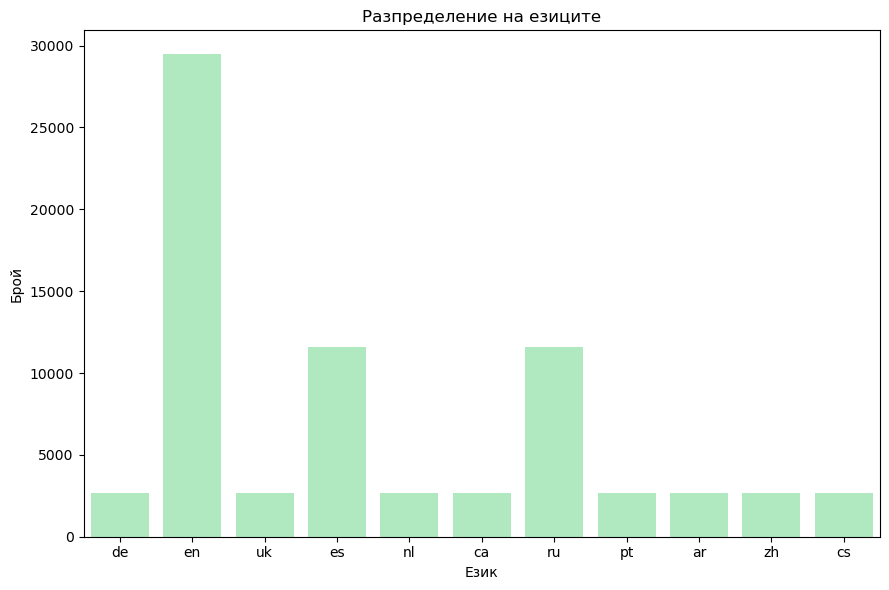

In [31]:
# Брой езици + графика
if 'language' in duplicate_data.columns:
    print("Брой записи по езици:")
    print(duplicate_data['language'].value_counts())

    # Графика
    plt.figure(figsize=(9, 6))
    sns.countplot(x='language', data=duplicate_data, color='#A6F3BC')
    plt.title('Разпределение на езиците')
    plt.ylabel('Брой')
    plt.xlabel('Език')
    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_9344\3749792275.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_lengths.index, y=avg_lengths.values, palette='Set2')


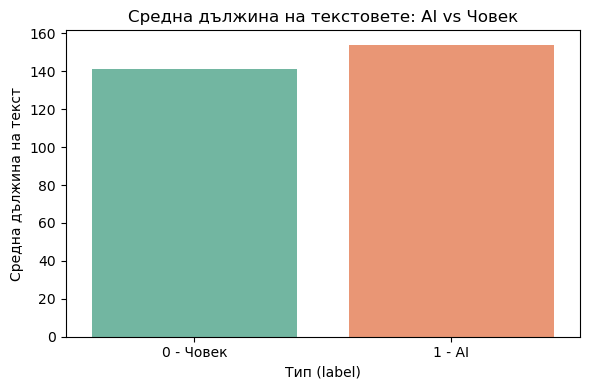

In [32]:
# Средната дължина на текстовете според този етикет 
avg_lengths = duplicate_data.groupby('label')['length'].mean()
avg_lengths.index = avg_lengths.index.map({0: '0 - Човек', 1: '1 - AI'})

plt.figure(figsize=(6, 4))
sns.barplot(x=avg_lengths.index, y=avg_lengths.values, palette='Set2')
plt.title('Средна дължина на текстовете: AI vs Човек')
plt.ylabel('Средна дължина на текст')
plt.xlabel('Тип (label)')
plt.tight_layout()
plt.show()

In [33]:
# Измерване на разнообразието на лексиката (Lexical Diversity)
languages = duplicate_data['language'].unique()

def get_top_words(df, lang, label, n=10):
    subset = df[(df['language'] == lang) & (df['label'] == label)]
    all_text = ' '.join(subset['text'].dropna()).lower()
    all_text = all_text.translate(str.maketrans('', '', string.punctuation))
    words = all_text.split()

    try:
        stop_words = set(stopwords.words(lang))
        words = [w for w in words if w not in stop_words]
    except:
        pass

    return Counter(words).most_common(n)
    
for lang in languages:
    for label in [0, 1]:  # 0 = човек, 1 = AI
        get_top_words(data, lang=lang, label=label)

def lexical_diversity(df, lang, label):
    subset = df[(df['language'] == lang) & (df['label'] == label)].copy()  
    subset.loc[:, 'word_count'] = subset['text'].apply(lambda x: len(x.split()))  
    subset.loc[:, 'unique_word_count'] = subset['text'].apply(lambda x: len(set(x.split())))
    subset.loc[:, 'lexical_diversity'] = subset['unique_word_count'] / subset['word_count']
    return subset['lexical_diversity'].mean()


# За човешки текстове на английски
lexical_diversity_human = lexical_diversity(data, lang='en', label=0)
print("Лексикално разнообразие за човешки текст:", lexical_diversity_human)

# За AI текстове на английски
lexical_diversity_ai = lexical_diversity(data, lang='en', label=1)
print("Лексикално разнообразие за AI:", lexical_diversity_ai)

Лексикално разнообразие за човешки текст: 0.6948176707091046
Лексикално разнообразие за AI: 0.6545827003975897


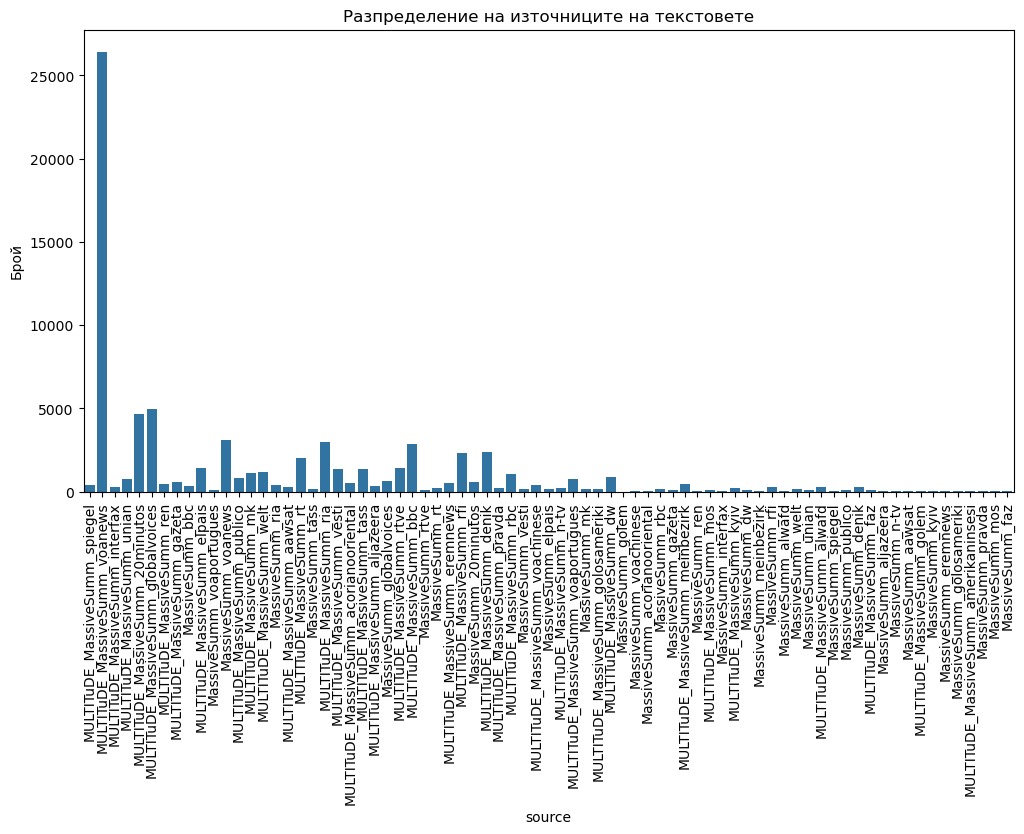

Топ 5 източника по брой текстове:
source
MULTITuDE_MassiveSumm_voanews         26434
MULTITuDE_MassiveSumm_globalvoices     4947
MULTITuDE_MassiveSumm_20minutos        4680
MassiveSumm_voanews                    3107
MULTITuDE_MassiveSumm_ria              2985
Name: count, dtype: int64


In [34]:
# Анализ на източниците на текста
plt.figure(figsize=(12, 6))
sns.countplot(x='source', data=duplicate_data)
plt.title('Разпределение на източниците на текстовете')
plt.xticks(rotation=90)
plt.ylabel('Брой')
plt.show()

top_sources = duplicate_data['source'].value_counts().head(5)
print("Топ 5 източника по брой текстове:")
print(top_sources)

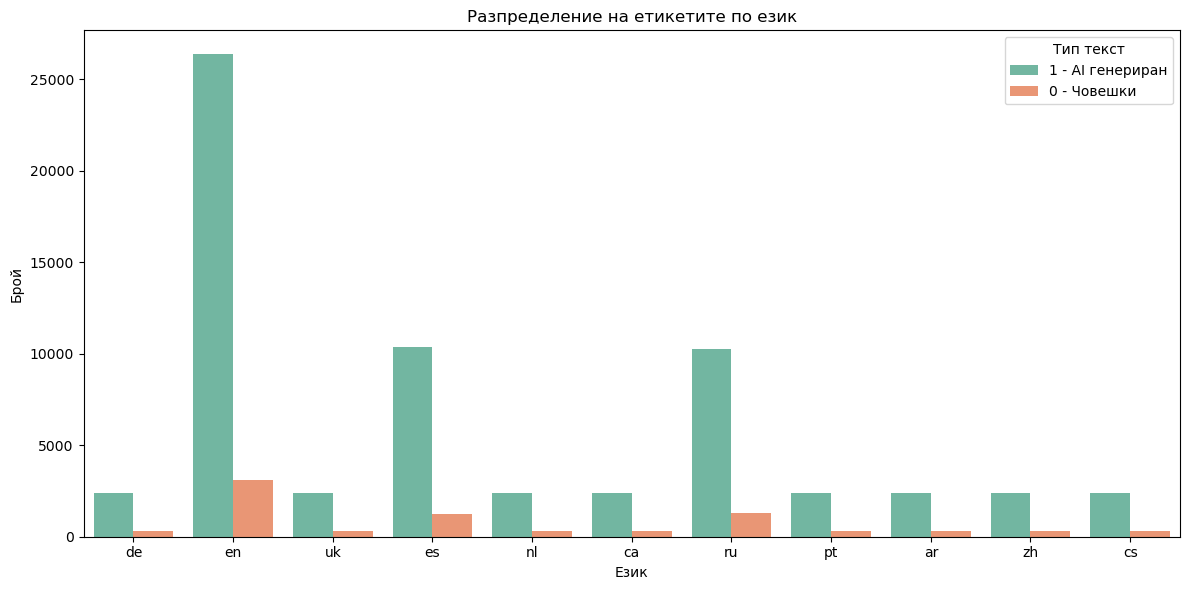

In [35]:
plt.figure(figsize=(12, 6))

# Преобразуваме само за визуализацията на hue
sns.countplot(
    x='language',
    hue=duplicate_data['label'].replace({0: '0 - Човешки', 1: '1 - AI генериран'}),
    data=duplicate_data,
    palette='Set2'
)

plt.title('Разпределение на етикетите по език')
plt.ylabel('Брой')
plt.xlabel('Език')
plt.legend(title='Тип текст')
plt.tight_layout()
plt.show()

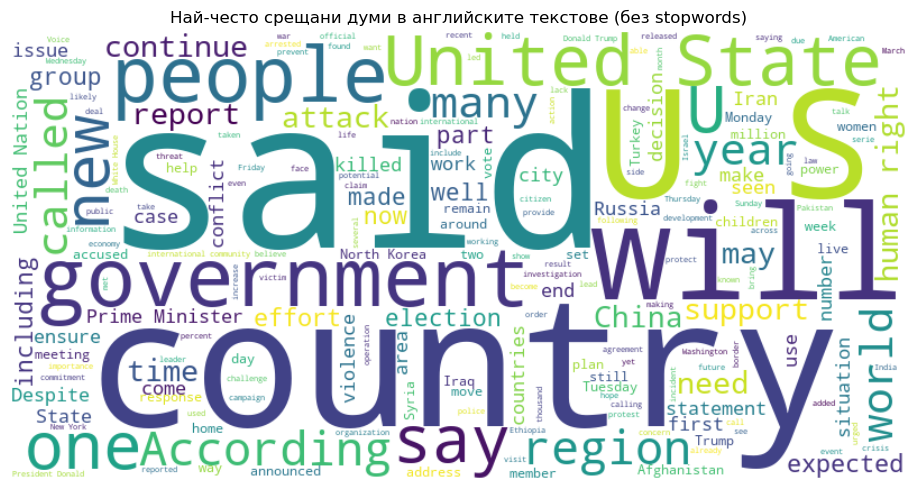

In [36]:
# Най-често използваните думи в английските текстове
en_texts = duplicate_data[duplicate_data['language'] == 'en']['text'].dropna().astype(str)

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(en_texts)
words = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

word_freq = pd.DataFrame({'word': words, 'count': counts})
top_words = word_freq.sort_values(by='count', ascending=False).head(20)
custom_stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(" ".join(en_texts))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Най-често срещани думи в английските текстове (без stopwords)')
plt.tight_layout()
plt.show()

split
train    44786
test     29295
Name: count, dtype: int64


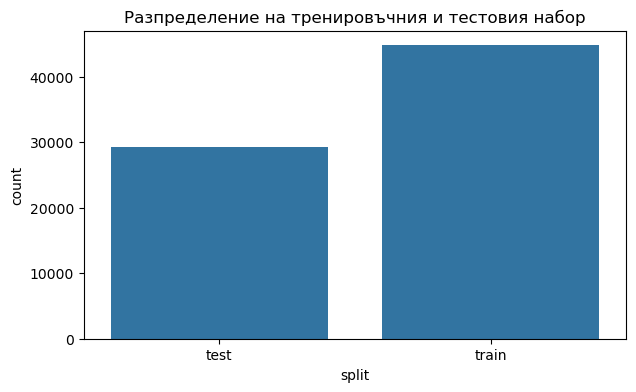

In [37]:
# Разпределение на тренировъчния и тестовия набор
# Колко примери са в тренировъчния и тестовия набор.
print(duplicate_data['split'].value_counts())

plt.figure(figsize=(7, 4))
sns.countplot(x='split', data=duplicate_data)
plt.title('Разпределение на тренировъчния и тестовия набор')
plt.show()

In [38]:
# Разделяне на данните въз основа на колоната 'split'
train_data = duplicate_data[duplicate_data['split'] == 'train']
test_data = duplicate_data[duplicate_data['split'] == 'test']

print(f"Езици в тренировъчния набор: {train_data['language'].value_counts()}")
print(f"Езици в тестовия набор: {test_data['language'].value_counts()}")

Езици в тренировъчния набор: language
en    26969
es     8910
ru     8907
Name: count, dtype: int64
Езици в тестовия набор: language
nl    2695
ca    2691
cs    2689
de    2685
zh    2683
es    2676
pt    2673
ar    2673
ru    2671
uk    2668
en    2491
Name: count, dtype: int64


In [39]:
# Понеже в тренировъчния имам 3 езика, изравняваме и в тестовия да има същите три
# Извличаме списъка с езиците от train_data (уникални стойности)
train_languages = train_data['language'].unique()
filtered_test_data = test_data[test_data['language'].isin(train_languages)]
print("Езици след филтриране на тестовия набор:")
print(filtered_test_data['language'].value_counts())

Езици след филтриране на тестовия набор:
language
es    2676
ru    2671
en    2491
Name: count, dtype: int64


In [40]:
filtered_test_data

,text,label,multi_label,split,language,length,source
7,International surgeons from around the world h...,1,alpaca-lora-30b,test,en,156,MULTITuDE_MassiveSumm_voanews
18,The construction of the Grand Ethiopian Renais...,1,gpt-3.5-turbo,test,en,272,MULTITuDE_MassiveSumm_voanews
28,Суд по делу об убийстве Бориса Немцова удовлет...,0,human,test,ru,79,MassiveSumm_bbc
46,The launch of the space shuttle Discovery has ...,1,gpt-3.5-turbo,test,en,171,MULTITuDE_MassiveSumm_voanews
54,El general Carlos Rojas durante el juicio cont...,1,opt-66b,test,es,212,MULTITuDE_MassiveSumm_rt
...,...,...,...,...,...,...,...
74025,Literatura inglesa: regular. Francés: prosa mu...,0,human,test,es,19,MassiveSumm_bbc
74043,A suicide bomber attacked a group of Chinese e...,1,gpt-3.5-turbo,test,en,156,MULTITuDE_MassiveSumm_voanews
74051,"Согласно информации, полученной от источников ...",1,vicuna-13b,test,ru,125,MULTITuDE_MassiveSumm_ria
74053,en un nuevo mar de la noche. Se desprende de s...,1,opt-iml-max-1.3b,test,es,182,MULTITuDE_MassiveSumm_20minutos


In [41]:
# Премахваме старите тестови данни с всички езици от duplicate_data
duplicate_data = duplicate_data[duplicate_data['split'] != 'test']

# Добавяме обратно само филтрираните редове
duplicate_data = pd.concat([duplicate_data, filtered_test_data], ignore_index=True)

print("Нови езици в duplicate_data за split='test':")
print(duplicate_data[duplicate_data['split'] == 'test']['language'].value_counts())

Нови езици в duplicate_data за split='test':
language
es    2676
ru    2671
en    2491
Name: count, dtype: int64


In [42]:
duplicate_data

,text,label,multi_label,split,language,length,source
0,Alex Azar was officially sworn in as the U.S. ...,1,text-davinci-003,train,en,57,MULTITuDE_MassiveSumm_voanews
1,"Yesterday, hundreds of Zambian university stud...",1,text-davinci-003,train,en,254,MULTITuDE_MassiveSumm_voanews
2,"In a narrow and highly watched vote, the US Se...",1,gpt-4,train,en,416,MULTITuDE_MassiveSumm_voanews
3,"In the aftermath of the Paris attacks, the Rep...",1,opt-66b,train,en,324,MULTITuDE_MassiveSumm_voanews
4,"Voice of America (VOA), the official broadcast...",1,text-davinci-003,train,en,22,MULTITuDE_MassiveSumm_voanews
...,...,...,...,...,...,...,...
52619,Literatura inglesa: regular. Francés: prosa mu...,0,human,test,es,19,MassiveSumm_bbc
52620,A suicide bomber attacked a group of Chinese e...,1,gpt-3.5-turbo,test,en,156,MULTITuDE_MassiveSumm_voanews
52621,"Согласно информации, полученной от источников ...",1,vicuna-13b,test,ru,125,MULTITuDE_MassiveSumm_ria
52622,en un nuevo mar de la noche. Se desprende de s...,1,opt-iml-max-1.3b,test,es,182,MULTITuDE_MassiveSumm_20minutos


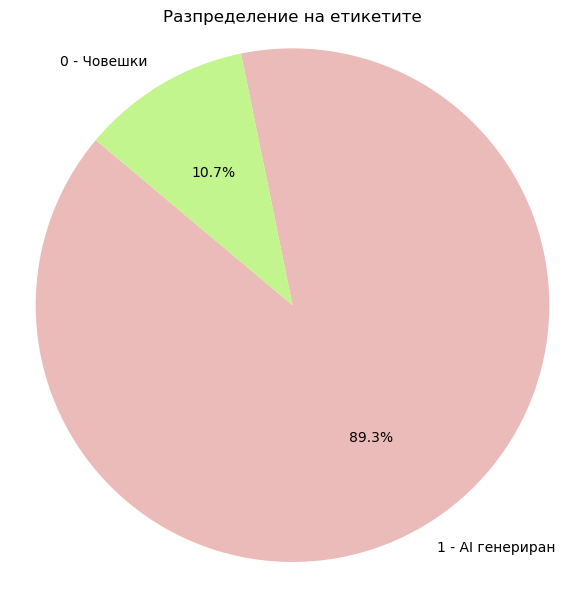

Човешки текстове (label = 0): 5617 (10.67%)
AI генерирани текстове (label = 1): 47007 (89.33%)


In [43]:
# Разпределение на етикети във duplicate_data
label_counts = duplicate_data['label'].value_counts()

labels = label_counts.index.map({0: '0 - Човешки', 1: '1 - AI генериран'})
sizes = label_counts.values
colors = ['#ebbbb9', '#c3f58e'] 

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Разпределение на етикетите')
plt.axis('equal') 
plt.tight_layout()
plt.show()

total = label_counts.sum()
percent_0 = (label_counts.get(0, 0) / total) * 100
percent_1 = (label_counts.get(1, 0) / total) * 100
print(f"Човешки текстове (label = 0): {label_counts.get(0, 0)} ({percent_0:.2f}%)")
print(f"AI генерирани текстове (label = 1): {label_counts.get(1, 0)} ({percent_1:.2f}%)")

Понеже записите на AI генерирания текст са много повече от човешките, може да повлияе на крайните резултати при използването на моделите. Затова най-подходящия начин да продължим е с under-sampling.

In [45]:
# Премахваме данни от 1-AI, за да стане балансиран дататсета
train_data = duplicate_data[duplicate_data['split'] == 'train']
test_data = duplicate_data[duplicate_data['split'] == 'test']

X_train = train_data['text']
y_train = train_data['label']

# Преобразуваме текстовете с TF-IDF само с английски стоп думи, защото не искаме да прихващаме думи като the, on, a, in ...
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)

# Прилагаме undersampling, за да балансираме label=0 и label=1
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train_vec, y_train)

# Създаваме нов DataFrame с оригиналните текстове (по индекси на undersampled)
balanced_indices = rus.sample_indices_
df_balanced = train_data.iloc[balanced_indices].reset_index(drop=True)

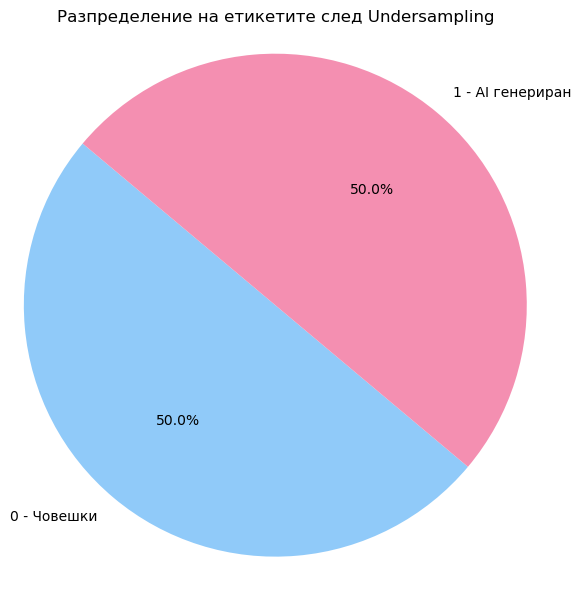

Човешки текстове (label = 0): 4756
AI генерирани текстове (label = 1): 4756


In [46]:
# Визуализираме след under-sampling
label_counts = df_balanced['label'].value_counts()
labels = label_counts.index.map({0: '0 - Човешки', 1: '1 - AI генериран'})
sizes = label_counts.values
colors = ['#90caf9', '#f48fb1']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Разпределение на етикетите след Undersampling')
plt.axis('equal')
plt.tight_layout()
plt.show()

count_0 = label_counts.get(0, 0)
count_1 = label_counts.get(1, 0)

print(f"Човешки текстове (label = 0): {count_0}")
print(f"AI генерирани текстове (label = 1): {count_1}")

Само 4756 текста са от човек в train_data, тъй като останалите 861 са в split='test'

In [48]:
df_balanced

,text,label,multi_label,split,language,length,source
0,Israeli security guards have foiled an alleged...,0,human,train,en,129,MassiveSumm_voanews
1,WASHINGTON - No matter what happens with the n...,0,human,train,en,241,MassiveSumm_voanews
2,Совещание с главами регионов Северного Кавказа...,0,human,train,ru,79,MassiveSumm_bbc
3,"НАЛЬЧИК, 28 авг — РИА Новости. Министерство ст...",0,human,train,ru,58,MassiveSumm_ria
4,"Fri, 02/05/2021 - 05:05 PMCOVID-19 Variants: U...",0,human,train,en,11,MassiveSumm_voanews
...,...,...,...,...,...,...,...
9507,Сегодня стало известно о трагическом инциденте...,1,gpt-4,train,ru,103,MULTITuDE_MassiveSumm_golosameriki
9508,"On July 12th, Dr. Fakhruddin Attar was arreste...",1,alpaca-lora-30b,train,en,93,MULTITuDE_MassiveSumm_voanews
9509,"В среду, двенадцатое февраля, власти Хельсинки...",1,text-davinci-003,train,ru,43,MULTITuDE_MassiveSumm_ria
9510,The United States Department of State has cond...,1,text-davinci-003,train,en,167,MULTITuDE_MassiveSumm_voanews


# Корелация

In [50]:
# Преобразуваме language по зададени стойности: en → 1, ru → 2, es → 3
df_balanced['language'] = df_balanced['language'].map({'en': 1, 'ru': 2, 'es': 3})

             label    length  language
label     1.000000  0.062082 -0.005646
length    0.062082  1.000000 -0.359993
language -0.005646 -0.359993  1.000000


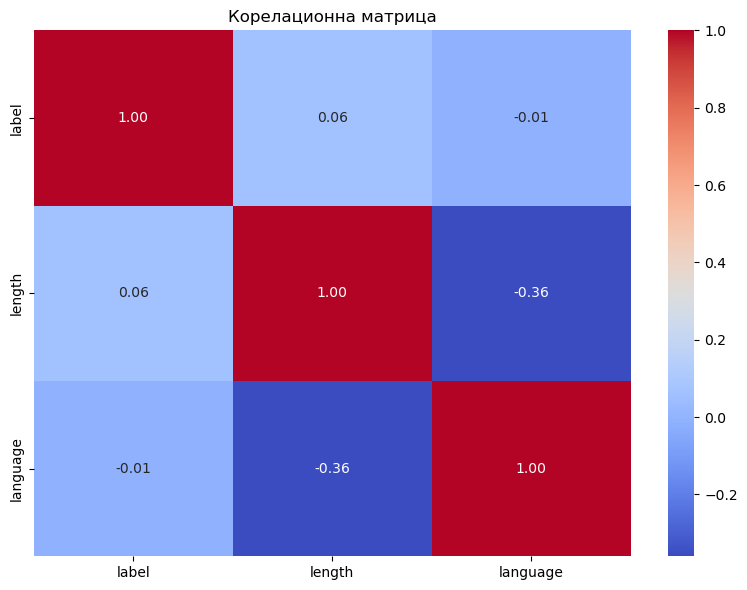

In [51]:
corr_data = df_balanced[['label', 'length', 'language']]
corr_matrix = corr_data.corr()

print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корелационна матрица')
plt.tight_layout()
plt.show()

# Разделяне на данните на train и test

In [53]:
X = df_balanced['text']
y = df_balanced['label']

# Разделяне: 70% train / 30% test
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42, stratify=y)

df_balanced['split'] = 'test'  
df_balanced.loc[X_train.index, 'split'] = 'train'  # Маркираме тренировъчните

print(df_balanced['split'].value_counts())

split
train    6658
test     2854
Name: count, dtype: int64


# Logistic Regression

In [55]:
train_df = df_balanced[df_balanced['split'] == 'train']
test_df = df_balanced[df_balanced['split'] == 'test']

# Настройваме pipeline: TF-IDF + логистична регресия
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(solver='liblinear', random_state=42))
])

pipeline.fit(train_df['text'], train_df['label'])

# Прогноза върху тестовите текстове
y_pred = pipeline.predict(test_df['text'])

print("\n📋 Classification Report:")
print(classification_report(test_df['label'], y_pred, digits=3))

cm = confusion_matrix(test_df['label'], y_pred)
tn_lr, fp_lr, fn_lr, tp_lr = cm.ravel()
accuracy_lr = accuracy_score(test_df['label'], y_pred)

print(f"\n Точност: {accuracy_lr * 100:.2f}%")
print(f" True Positive rate :  {tp_lr} from {tp_lr + fn_lr}")
print(f" True Negative rate :  {tn_lr} from {tn_lr + fp_lr}")
print(f" False Positive rate :  {fp_lr} from {fp_lr + tn_lr}")
print(f" False Negative rate :  {fn_lr} from {fn_lr + tp_lr}")


📋 Classification Report:
              precision    recall  f1-score   support

           0      0.776     0.819     0.797      1427
           1      0.809     0.764     0.786      1427

    accuracy                          0.792      2854
   macro avg      0.792     0.792     0.791      2854
weighted avg      0.792     0.792     0.791      2854


 Точност: 79.15%
 True Positive rate :  1090 from 1427
 True Negative rate :  1169 from 1427
 False Positive rate :  258 from 1427
 False Negative rate :  337 from 1427


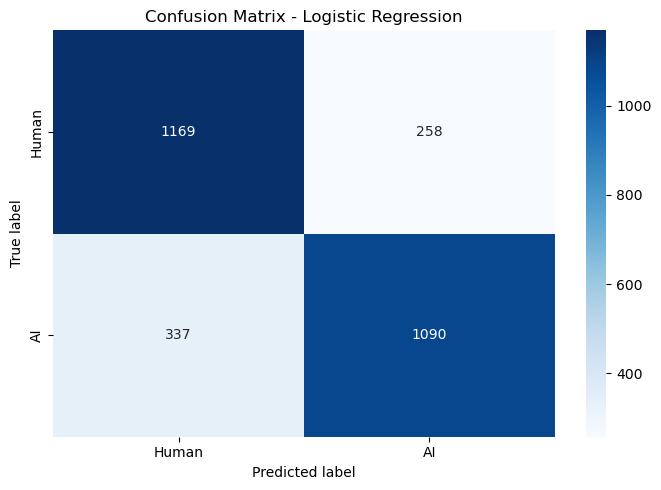

In [56]:
# Визуализация на confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(test_df['label'], y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

## Изводи за логистичната регресия:
Моделът постигна точност от 79.15%, което е стабилен резултат, предвид че работи със сходни по стил текстове, генерирани от хора и AI. Важно е, че той улавя добре двата класа, макар и с известен компромис в точността спрямо някои случаи.

### True Positive Rate (чувствителност):
Моделът е открил 1090 от общо 1427 AI текста, което показва, че успешно разпознава значителна част от изкуствено генерираните текстове. Този показател разкрива колко ефективен е моделът в идентифицирането на AI съдържание

### True Negative Rate (специфичност):
Успешно са класифицирани 1169 от 1427 човешки текста, което говори за добра способност на модела да разграничава автентични, човешки съобщения. Това е ключово, за да се избегнат погрешни обвинения към реално написани от хора текстове.

### False Positive Rate:
258 от човешките текстове са били сгрешени като AI, което показва известно количество "прекомерна подозрителност" от страна на модела.

### False Negative Rate
337 от AI текстовете са били разпознати като човешки, което означава, че има място за подобрение при улавянето на по-естествено звучащи изкуствени формулировки.

Балансът между precision и recall е добър и за двата класа, което подсказва, че моделът е стабилен и няма сериозен bias в едната посока.

# Naive Bayes

In [59]:
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn_nb, fp_nb, fn_nb, tp_nb = cm.ravel()
accuracy_nb = accuracy_score(y_test, y_pred)

print(f"\n Точност: {accuracy_nb * 100:.2f}%")
print(f" True Positive rate :  {tp_nb} from {tp_nb + fn_nb}")
print(f" True Negative rate :  {tn_nb} from {tn_nb + fp_nb}")
print(f" False Positive rate :  {fp_nb} from {fp_nb + tn_nb}")
print(f" False Negative rate :  {fn_nb} from {fn_nb + tp_nb}")

print("\n Confusion Matrix:")
print(cm)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, digits=3))


 Точност: 74.67%
 True Positive rate :  1115 from 1427
 True Negative rate :  1016 from 1427
 False Positive rate :  411 from 1427
 False Negative rate :  312 from 1427

 Confusion Matrix:
[[1016  411]
 [ 312 1115]]

 Classification Report:
              precision    recall  f1-score   support

           0      0.765     0.712     0.738      1427
           1      0.731     0.781     0.755      1427

    accuracy                          0.747      2854
   macro avg      0.748     0.747     0.746      2854
weighted avg      0.748     0.747     0.746      2854



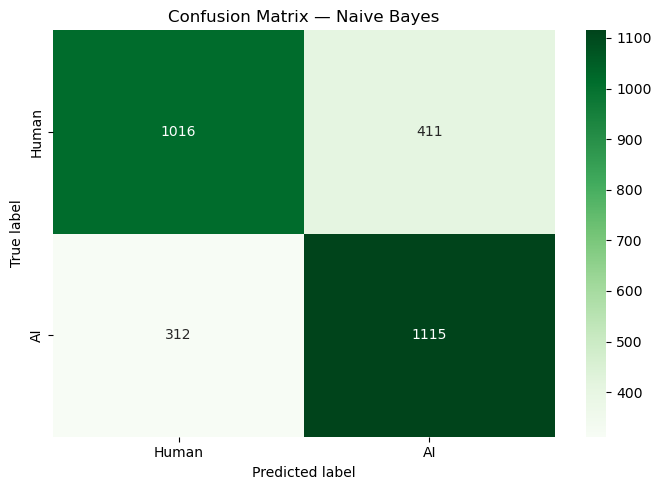

In [60]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Naive Bayes")
plt.tight_layout()
plt.show()

## Изводи за Naive Bayes:
74.67% – моделът класифицира правилно почти 3 от всеки 4 текста. Това е по-ниска точност спрямо Logistic Regression, но приемлива за бърз и интерпретируем модел.

### True Positive Rate (чувствителност):
Моделът успешно е открил 1115 от 1427 AI текстове (78.1%) → Добра способност да разпознава изкуствено съдържание.

### True Negative Rate (специфичност):
Успешно са класифицирани 1016 от 1427 човешки текстове (71.2%) → Моделът има известна склонност да обърква човешки текст с AI (FP = 411).

### False Negatives (пропуснати AI текстове):
312 от AI текстовете са класифицирани като човешки → Това означава, че определена част от изкуствените текстове звучат толкова естествено, че объркват модела. → При чувствителни приложения, като откриване на AI измами или автоматично съдържание, това би било критично.

### False Positives (грешно класифицирани човешки текстове):
411 човешки текста са сгрешени като AI → Това е сравнително висока стойност, което подсказва, че моделът е „по-подозрителен“ и склонен да маркира някои човешки текстове като изкуствени. → Това може да доведе до фалшиви тревоги, ако искаме да идентифицираме AI съдържание с висока прецизност.

Моделът е по-чувствителен към AI (улавя повече от тях), но е по-прецизен при разпознаване на човешки текстове.

# Random Forest

In [63]:
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn_rf, fp_rf, fn_rf, tp_rf = cm.ravel()
accuracy_rf = accuracy_score(y_test, y_pred)

print(f"\n Точност: {accuracy_rf * 100:.2f}%")
print(f" True Positive rate :  {tp_rf} from {tp_rf + fn_rf}")
print(f" True Negative rate :  {tn_rf} from {tn_rf + fp_rf}")
print(f" False Positive rate :  {fp_rf} from {fp_rf + tn_rf}")
print(f" False Negative rate :  {fn_rf} from {fn_rf + tp_rf}")

print("\n Confusion Matrix:")
print(cm)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, digits=3))


 Точност: 81.15%
 True Positive rate :  1103 from 1427
 True Negative rate :  1213 from 1427
 False Positive rate :  214 from 1427
 False Negative rate :  324 from 1427

 Confusion Matrix:
[[1213  214]
 [ 324 1103]]

 Classification Report:
              precision    recall  f1-score   support

           0      0.789     0.850     0.818      1427
           1      0.838     0.773     0.804      1427

    accuracy                          0.811      2854
   macro avg      0.813     0.811     0.811      2854
weighted avg      0.813     0.811     0.811      2854



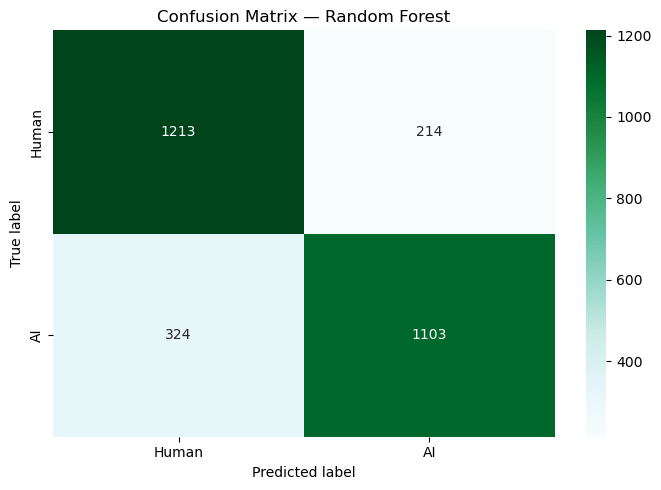

In [64]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()

## Изводи за Random Forest:
81.15% Най-висока точност досега от тестваните модели — класифицира вярно над 8 от 10 текста, което е отличен резултат.

### True Positive Rate (чувствителност):
Открити са 1103 от 1427 AI текстове (recall = 77.3%) → Моделът има силна способност да разпознава изкуствено съдържание.

### True Negative Rate (специфичност):
Разпознати са 1213 от 1427 човешки текстове (recall = 85.0%) → Отлично справяне при разграничаване на автентичен човешки език.

### False Negatives (пропуснати AI текстове):
324 текста не са разпознати като генерирани. Това подсказва, че някои AI текстове звучат прекалено „естествено“

### False Positives (грешно класифицирани човешки текстове):
214 човешки текста са класифицирани неправилно като AI. По-ниска стойност спрямо предходните модели.

Random Forest постига най-силни резултати досега. Успява да балансира между прецизност и чувствителност, като редуцира и FP, и FN.

# Изводи

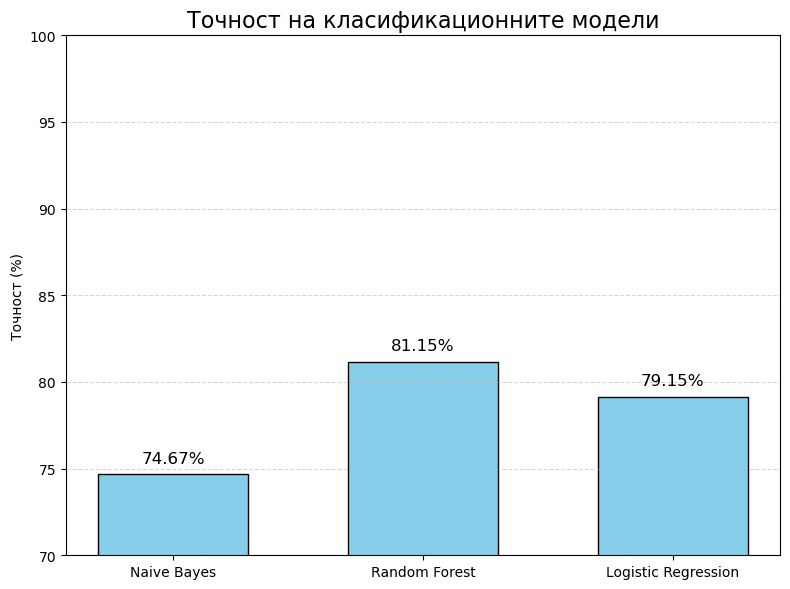

In [67]:
models = ["Naive Bayes", "Random Forest", "Logistic Regression"]
accuracies = [accuracy_nb, accuracy_rf, accuracy_lr]

accuracies_percent = [acc * 100 for acc in accuracies]

# Графика
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies_percent, color='skyblue', edgecolor='black', width=0.6)

plt.title('Точност на класификационните модели', fontsize=16)
plt.ylabel('Точност (%)')
plt.ylim(70, 100)  # Минимална стойност 70%

# Добавяне на стойности върху колоните
for bar, acc in zip(bars, accuracies_percent):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{acc:.2f}%', 
             ha='center', va='bottom', fontsize=12, color='black')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [68]:
tpr_rates = [tp_nb / (tp_nb + fn_nb),
             tp_rf / (tp_rf + fn_rf),
             tp_lr / (tp_lr + fn_lr)]

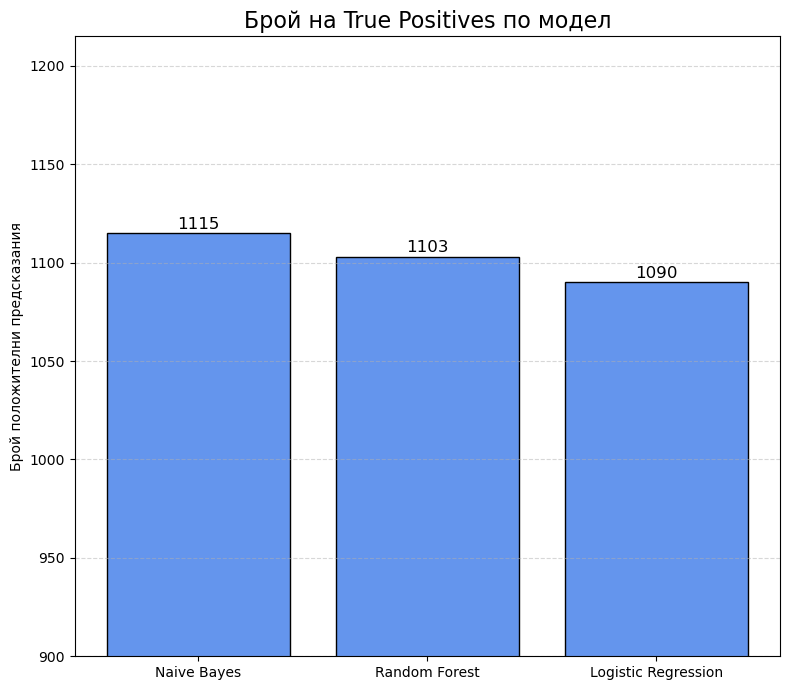

In [69]:
# Абсолютен брой True Positives за всеки модел
tp_counts = [tp_nb, tp_rf, tp_lr]

plt.figure(figsize=(8, 7))
bars = plt.bar(models, tp_counts, color='cornflowerblue', edgecolor='black')
plt.title('Брой на True Positives по модел', fontsize=16)
plt.ylabel('Брой положителни предсказания')
plt.ylim(900, max(tp_counts) + 100)

for bar, tp in zip(bars, tp_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.8, f'{tp}', 
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

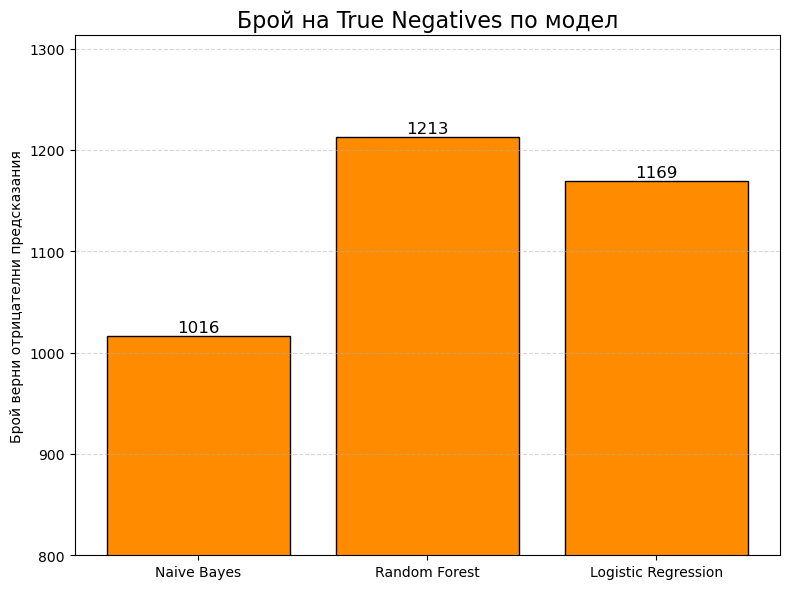

In [70]:
tn_counts = [tn_nb, tn_rf, tn_lr] 

plt.figure(figsize=(8, 6))
bars = plt.bar(models, tn_counts, color='darkorange', edgecolor='black')
plt.title('Брой на True Negatives по модел', fontsize=16)
plt.ylabel('Брой верни отрицателни предсказания')
plt.ylim(800, max(tn_counts) + 100)

for bar, tn in zip(bars, tn_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{tn}', 
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

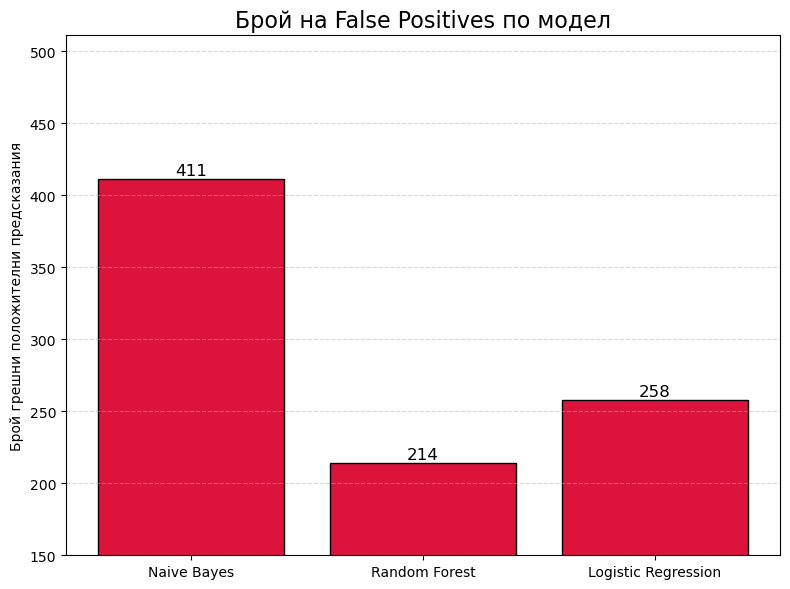

In [71]:
fp_counts = [fp_nb, fp_rf, fp_lr] 

plt.figure(figsize=(8, 6))
bars = plt.bar(models, fp_counts, color='crimson', edgecolor='black')
plt.title('Брой на False Positives по модел', fontsize=16)
plt.ylabel('Брой грешни положителни предсказания')
plt.ylim(150, max(fp_counts) + 100)

for bar, fp in zip(bars, fp_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.8, f'{fp}', 
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

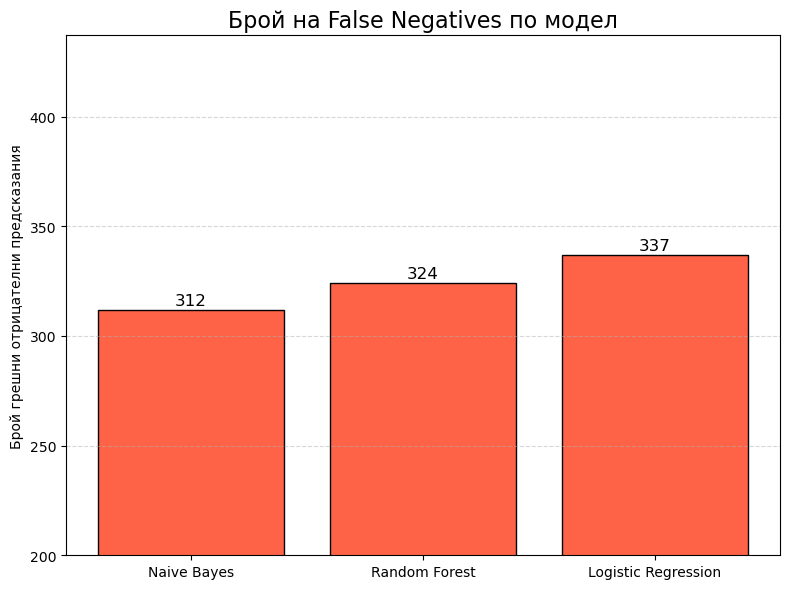

In [72]:
fn_counts = [fn_nb, fn_rf, fn_lr] 

plt.figure(figsize=(8, 6))
bars = plt.bar(models, fn_counts, color='tomato', edgecolor='black')
plt.title('Брой на False Negatives по модел', fontsize=16)
plt.ylabel('Брой грешни отрицателни предсказания')
plt.ylim(200, max(fn_counts) + 100)

for bar, fn in zip(bars, fn_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.8, f'{fn}', 
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()